In [1]:
"""
Benchmark: 1D Schnakenberg Reaction-Diffusion System
====================================================

This benchmark compares the performance of implicit Runge-Kutta solvers
when using sparse versus dense Jacobian representations.

Problem description
-------------------
We solve the Schnakenberg reaction-diffusion system in 1D:

    ∂u/∂t = D_u ∂²u/∂x² + a - u + u²v
    ∂v/∂t = D_v ∂²v/∂x² + b - u²v

on the spatial domain x ∈ (0, 1) with homogeneous Dirichlet boundary
conditions (u = v = 0 at the boundaries). The parameters are:

    a = 0.2,    b = 1.3
    D_u = 1e-3, D_v = 5e-3

Discretization
--------------
The spatial domain is discretized with N interior points and uniform
grid spacing h = 1 / (N + 1). A standard finite-difference Laplacian
is used for the diffusion operator. This yields a system of ODEs in
time of dimension 2N:

    U = (u₁, ..., u_N, v₁, ..., v_N)ᵀ ∈ ℝ²ᴺ.

ODE System
----------
The resulting semi-discrete system is integrated in time with an
implicit Runge-Kutta scheme (SDIRK(3,4) by Nørsett-Thompson). The
benchmark compares two implementations of the Jacobian:

    • Dense Jacobian: stored and factored as a full 2N x 2N matrix.
    • Sparse Jacobian: block sparse representation with CSR format.

Goal
----
To measure the impact of Jacobian sparsity on runtime efficiency
for moderately large problems (here N = 200).

Expected behavior:
- Sparse storage/factorization should reduce computational cost and
  memory footprint compared to the dense approach.
"""

import time
import numpy as np
import scipy.sparse as sp
from scipy.sparse import diags, bmat
from matplotlib import pyplot as plt

from pyodys import ODEProblem, ButcherTableau, RKSolverWithButcherTableau


In [2]:


# ---------------------------------------------------------------------------
# Model parameters
# ---------------------------------------------------------------------------
a, b = 0.2, 1.3        # Schnakenberg reaction parameters
D_u, D_v = 1e-3, 5e-3  # Diffusion coefficients

# ---------------------------------------------------------------------------
# Utilities
# ---------------------------------------------------------------------------
def laplacian_1d(N: int, h: float) -> sp.csr_matrix:
    """Construct 1D Laplacian with Dirichlet BC."""
    main_diag = -2.0 * np.ones(N)
    off_diag = np.ones(N-1)
    return diags([off_diag, main_diag, off_diag], [-1,0,1], format='csr') / (h**2)

# ---------------------------------------------------------------------------
# Schnakenberg 1D problem
# ---------------------------------------------------------------------------
class Schnakenberg1D(ODEProblem):
    """1D Schnakenberg reaction-diffusion system."""
    
    def __init__(self, N: int, t_init: float, t_final: float, force_dense: bool = False):
        self.N = N
        self.h = 1.0 / (N + 1)
        self.x = np.linspace(self.h, 1.0 - self.h, N)
        self.force_dense = force_dense

        # Steady-state solution with perturbation
        u0 = a + b
        v0 = b / (a + b)**2
        rng = np.random.default_rng(12345)
        perturb = 0.02 * rng.standard_normal(size=(N,))
        U = u0 + perturb
        V = v0 + perturb
        initial_state = np.hstack([U, V])

        self.L = laplacian_1d(N, self.h)
        super().__init__(t_init, t_final, initial_state, jacobian_is_constant=False, mass_matrix_is_identity=True)

    def evaluate_at(self, t: float, U: np.ndarray) -> np.ndarray:
        u = U[:self.N]
        v = U[self.N:]
        rhs_u = D_u * self.L.dot(u) + (a - u + u**2 * v)
        rhs_v = D_v * self.L.dot(v) + (b - u**2 * v)
        return np.concatenate([rhs_u, rhs_v])

    def jacobian_at(self, t: float, U: np.ndarray):
        u = U[:self.N]
        v = U[self.N:]
        n = self.N
        if self.force_dense:
            J = np.zeros((2*n, 2*n))
            J[:n,:n] = D_u*self.L.toarray() + np.diag(-1 + 2*u*v)
            J[:n,n:] = np.diag(u**2)
            J[n:,:n] = np.diag(-2*u*v)
            J[n:,n:] = D_v*self.L.toarray() + np.diag(-u**2)
            return J
        else:
            R_uu = diags(-1 + 2*u*v, 0, format='csr')
            R_uv = diags(u**2, 0, format='csr')
            R_vu = diags(-2*u*v, 0, format='csr')
            R_vv = diags(-u**2, 0, format='csr')
            A11 = D_u * self.L + R_uu
            A12 = R_uv
            A21 = R_vu
            A22 = D_v * self.L + R_vv
            return bmat([[A11,A12],[A21,A22]], format='csr')



In [3]:
# ---------------------------------------------------------------------------
# Benchmark setup
# ---------------------------------------------------------------------------
N = 200
t_init, t_final = 0.0, 2.0

prob_sparse = Schnakenberg1D(N, t_init, t_final, force_dense=False)
prob_dense  = Schnakenberg1D(N, t_init, t_final, force_dense=True)

solver_opts = {
    "butcher_tableau": ButcherTableau.from_name("esdirk6"),
    "initial_step_size": 1e-6,
    "adaptive_time_stepping": True,
    "min_step_size": 1e-8,
    "max_step_size": 1e-1,
    "target_relative_error": 1e-8
}

solver_sparse = RKSolverWithButcherTableau(auto_check_sparsity =True, **solver_opts)
solver_dense  = RKSolverWithButcherTableau(auto_check_sparsity =False, **solver_opts)

# ---------------------------------------------------------------------------
# Solve
# ---------------------------------------------------------------------------
t0 = time.perf_counter()
times_sparse, sols_sparse = solver_sparse.solve(prob_sparse)
elapsed_sparse = time.perf_counter() - t0

t0 = time.perf_counter()
times_dense, sols_dense = solver_dense.solve(prob_dense)
elapsed_dense = time.perf_counter() - t0

print(f"Sparse solver CPU time: {elapsed_sparse:.3f} s")
print(f"Dense solver CPU time:  {elapsed_dense:.3f} s")



Sparse Jacobian returned by user: size=400x400, density=9.975e-03
Jacobian marked as variable → will be recomputed at each stage refresh.
Successfully pre-allocated memory for the solution array.
Time step #39 completed. Current time: 0.0213
Time step #49 completed. Current time: 0.0402
Time step #56 completed. Current time: 0.0613
Time step #61 completed. Current time: 0.0821
Time step #65 completed. Current time: 0.1035
Time step #68 completed. Current time: 0.1228
Time step #71 completed. Current time: 0.1456
Time step #73 completed. Current time: 0.1629
Time step #75 completed. Current time: 0.1822
Time step #77 completed. Current time: 0.2036
Time step #79 completed. Current time: 0.2275
Time step #80 completed. Current time: 0.2404
Time step #82 completed. Current time: 0.2682
Time step #83 completed. Current time: 0.2833
Time step #85 completed. Current time: 0.3158
Time step #86 completed. Current time: 0.3334
Time step #87 completed. Current time: 0.3519
Time step #88 complete

Time step #113 completed. Current time: 1.3601
Time step #114 completed. Current time: 1.4282
Time step #115 completed. Current time: 1.4992
Time step #116 completed. Current time: 1.5732
Time step #117 completed. Current time: 1.6501
Time step #118 completed. Current time: 1.7302
Time step #119 completed. Current time: 1.8135
Time step #120 completed. Current time: 1.9001
Time step #121 completed. Current time: 1.9901
Time step #122 completed. Current time: 2.0000
The total number of time steps required to reach t_final = 2.0 is 122.
Dense Jacobian returned by user, using dense: size=400x400
Jacobian marked as variable → will be recomputed at each stage refresh.
Successfully pre-allocated memory for the solution array.


Time step #39 completed. Current time: 0.0213


Time step #49 completed. Current time: 0.0402


Time step #56 completed. Current time: 0.0613


Time step #61 completed. Current time: 0.0821


Time step #65 completed. Current time: 0.1035


Time step #68 completed. Current time: 0.1228


Time step #71 completed. Current time: 0.1456


Time step #73 completed. Current time: 0.1629


Time step #75 completed. Current time: 0.1822


Time step #77 completed. Current time: 0.2036


Time step #79 completed. Current time: 0.2275


Time step #80 completed. Current time: 0.2404


Time step #82 completed. Current time: 0.2682


Time step #83 completed. Current time: 0.2833


Time step #85 completed. Current time: 0.3158


Time step #86 completed. Current time: 0.3334


Time step #87 completed. Current time: 0.3519


Time step #88 completed. Current time: 0.3714


Time step #89 completed. Current time: 0.3919


Time step #90 completed. Current time: 0.4135


Time step #91 completed. Current time: 0.4362


Time step #92 completed. Current time: 0.4601


Time step #93 completed. Current time: 0.4852


Time step #94 completed. Current time: 0.5117


Time step #95 completed. Current time: 0.5396


Time step #96 completed. Current time: 0.5688


Time step #97 completed. Current time: 0.5996


Time step #98 completed. Current time: 0.6320


Time step #99 completed. Current time: 0.6661


Time step #100 completed. Current time: 0.7018


Time step #101 completed. Current time: 0.7394


Time step #102 completed. Current time: 0.7788


Time step #103 completed. Current time: 0.8203


Time step #104 completed. Current time: 0.8637


Time step #105 completed. Current time: 0.9093


Time step #106 completed. Current time: 0.9572


Time step #107 completed. Current time: 1.0073


Time step #108 completed. Current time: 1.0597


Time step #109 completed. Current time: 1.1146


Time step #110 completed. Current time: 1.1720


Time step #111 completed. Current time: 1.2320


Time step #112 completed. Current time: 1.2947


Time step #113 completed. Current time: 1.3601


Time step #114 completed. Current time: 1.4282


Time step #115 completed. Current time: 1.4992


Time step #116 completed. Current time: 1.5732


Time step #117 completed. Current time: 1.6501


Time step #118 completed. Current time: 1.7302


Time step #119 completed. Current time: 1.8135


Time step #120 completed. Current time: 1.9001


Time step #121 completed. Current time: 1.9901


Time step #122 completed. Current time: 2.0000
The total number of time steps required to reach t_final = 2.0 is 122.
Sparse solver CPU time: 0.221 s
Dense solver CPU time:  62.113 s


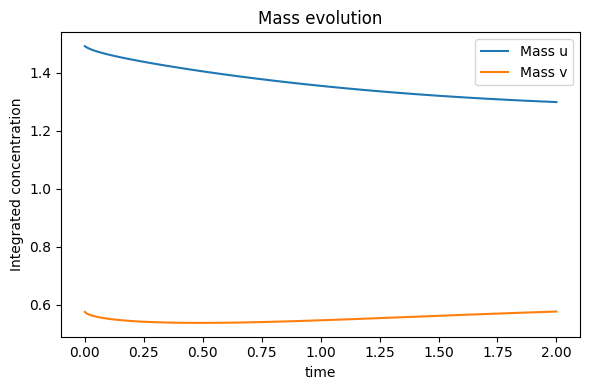

In [4]:
# ---------------------------------------------------------------------------
# Mass evolution
# ---------------------------------------------------------------------------
U_all = sols_sparse[:, :N]
V_all = sols_sparse[:, N:]

mass_u = U_all @ np.ones(N) * prob_sparse.h
mass_v = V_all @ np.ones(N) * prob_sparse.h

plt.figure(figsize=(6,4))
plt.plot(times_sparse, mass_u, label='Mass u')
plt.plot(times_sparse, mass_v, label='Mass v')
plt.xlabel('time')
plt.ylabel('Integrated concentration')
plt.title('Mass evolution')
plt.legend()
plt.tight_layout()
plt.show()



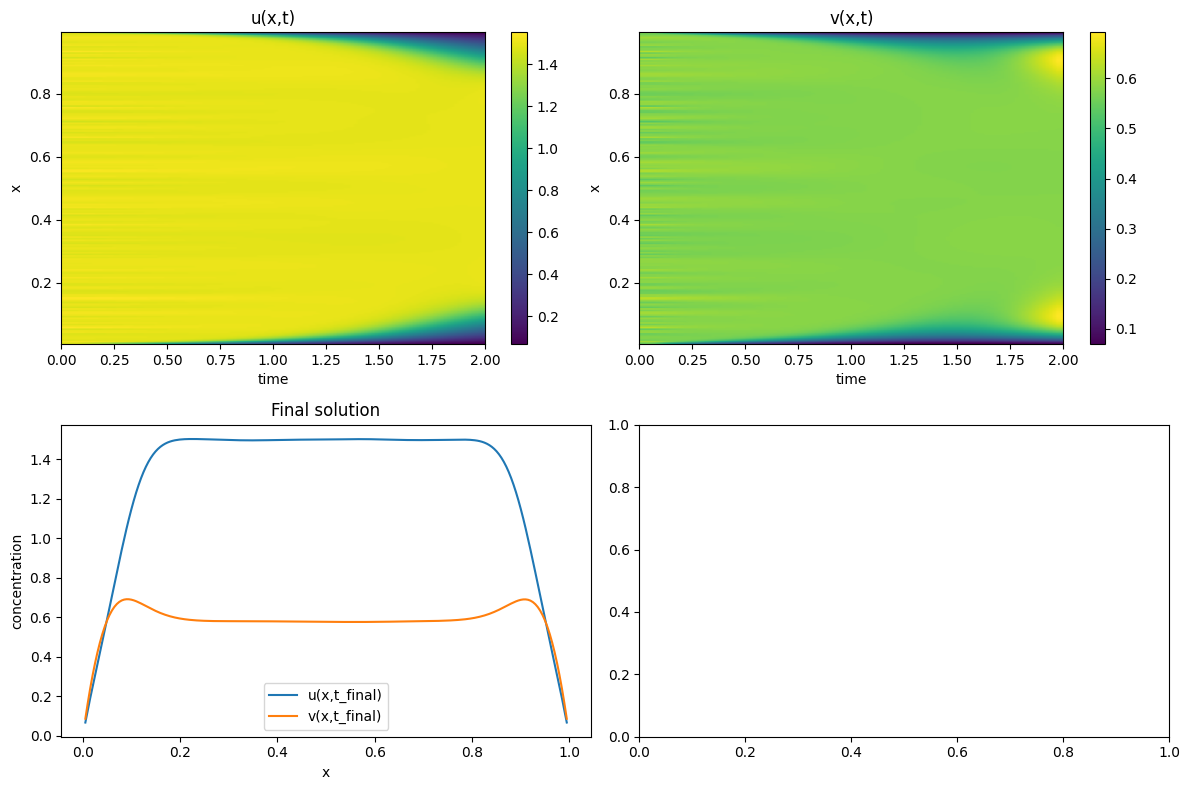

In [5]:
# ---------------------------------------------------------------------------
# Spatio-temporal solution
# ---------------------------------------------------------------------------
fig, axes = plt.subplots(2,2, figsize=(12,8))

# Heatmap u
im1 = axes[0,0].imshow(U_all.T, extent=[t_init, t_final, prob_sparse.x[0], prob_sparse.x[-1]],
                        aspect='auto', origin='lower', cmap='viridis')
axes[0,0].set_title("u(x,t)")
axes[0,0].set_xlabel("time")
axes[0,0].set_ylabel("x")
fig.colorbar(im1, ax=axes[0,0])

# Heatmap v
im2 = axes[0,1].imshow(V_all.T, extent=[t_init, t_final, prob_sparse.x[0], prob_sparse.x[-1]],
                        aspect='auto', origin='lower', cmap='viridis')
axes[0,1].set_title("v(x,t)")
axes[0,1].set_xlabel("time")
axes[0,1].set_ylabel("x")
fig.colorbar(im2, ax=axes[0,1])

# Final snapshot
axes[1,0].plot(prob_sparse.x, U_all[-1], label='u(x,t_final)')
axes[1,0].plot(prob_sparse.x, V_all[-1], label='v(x,t_final)')
axes[1,0].set_title("Final solution")
axes[1,0].set_xlabel("x")
axes[1,0].set_ylabel("concentration")
axes[1,0].legend()

plt.tight_layout()
plt.show()



In [6]:
# ---------------------------------------------------------------------------
# CPU-Time vs N
# ---------------------------------------------------------------------------
Ns = [25, 50, 100, 200, 400, 800, 1600]  # grid sizes
t_final = 0.2             # short final time for benchmarking

results = []

for N in Ns:
    prob_sparse = Schnakenberg1D(N, 0.0, t_final, force_dense=False)
    prob_dense  = Schnakenberg1D(N, 0.0, t_final, force_dense=True)
    
    # Sparse solver
    solver_sparse = RKSolverWithButcherTableau(auto_check_sparsity =True, **solver_opts)
    t0 = time.perf_counter()
    solver_sparse.solve(prob_sparse)
    t_sparse = time.perf_counter() - t0
    
    # Dense solver
    solver_dense = RKSolverWithButcherTableau(auto_check_sparsity =False, **solver_opts)
    t0 = time.perf_counter()
    solver_dense.solve(prob_dense)
    t_dense = time.perf_counter() - t0
    
    results.append((N, 2*N, t_dense, t_sparse))

# Print LaTeX table
print("\\begin{table}[ht!]")
print("\\centering")
print("\\begin{tabular}{c|c|c|c}")
print("\\hline")
print("$N$ & Degrees of freedom ($2N$) & Dense solver & Sparse solver \\\\")
print("\\hline")
for N, dof, t_dense, t_sparse in results:
    print(f"{N} & {dof} & {t_dense:.3f} & {t_sparse:.3f} \\\\")
print("\\hline")
print("\\end{tabular}")
print("\\caption{CPU runtimes (in seconds) for the 1D Schnakenberg reaction--diffusion system solved with SDIRK(3,4). Comparison between dense and sparse Jacobian solvers.}")
print("\\label{tab:schnakenberg1d}")
print("\\end{table}")


Sparse Jacobian returned by user: size=50x50, density=7.840e-02
Jacobian marked as variable → will be recomputed at each stage refresh.
Successfully pre-allocated memory for the solution array.
Time step #7 completed. Current time: 0.0070
Time step #8 completed. Current time: 0.0200
Time step #9 completed. Current time: 0.0345
Time step #10 completed. Current time: 0.0496
Time step #11 completed. Current time: 0.0653
Time step #12 completed. Current time: 0.0816
Time step #13 completed. Current time: 0.0986
Time step #14 completed. Current time: 0.1162
Time step #15 completed. Current time: 0.1346
Time step #16 completed. Current time: 0.1539
Time step #17 completed. Current time: 0.1740
Time step #18 completed. Current time: 0.1952
Time step #19 completed. Current time: 0.2000
The total number of time steps required to reach t_final = 0.2 is 19.
Dense Jacobian returned by user, using dense: size=50x50
Jacobian marked as variable → will be recomputed at each stage refresh.
Successfully

Time step #7 completed. Current time: 0.0024
Time step #9 completed. Current time: 0.0046
Time step #11 completed. Current time: 0.0071
Time step #12 completed. Current time: 0.0083
Time step #14 completed. Current time: 0.0111
Time step #15 completed. Current time: 0.0125
Time step #16 completed. Current time: 0.0140
Time step #18 completed. Current time: 0.0173
Time step #19 completed. Current time: 0.0190
Time step #20 completed. Current time: 0.0208
Time step #21 completed. Current time: 0.0227
Time step #22 completed. Current time: 0.0247
Time step #23 completed. Current time: 0.0268
Time step #24 completed. Current time: 0.0290
Time step #25 completed. Current time: 0.0313
Time step #26 completed. Current time: 0.0338
Time step #27 completed. Current time: 0.0364
Time step #28 completed. Current time: 0.0391
Time step #29 completed. Current time: 0.0420
Time step #30 completed. Current time: 0.0451
Time step #31 completed. Current time: 0.0483
Time step #32 completed. Current tim

Time step #43 completed. Current time: 0.0276
Time step #44 completed. Current time: 0.0294
Time step #45 completed. Current time: 0.0313
Time step #46 completed. Current time: 0.0333
Time step #47 completed. Current time: 0.0355
Time step #48 completed. Current time: 0.0377
Time step #49 completed. Current time: 0.0402
Time step #50 completed. Current time: 0.0427
Time step #51 completed. Current time: 0.0454
Time step #52 completed. Current time: 0.0482
Time step #53 completed. Current time: 0.0512
Time step #54 completed. Current time: 0.0544
Time step #55 completed. Current time: 0.0577
Time step #56 completed. Current time: 0.0613
Time step #57 completed. Current time: 0.0650
Time step #58 completed. Current time: 0.0689
Time step #59 completed. Current time: 0.0731
Time step #60 completed. Current time: 0.0775
Time step #61 completed. Current time: 0.0821
Time step #62 completed. Current time: 0.0870
Time step #63 completed. Current time: 0.0922
Time step #64 completed. Current t

Time step #11 completed. Current time: 0.0020


Time step #17 completed. Current time: 0.0042


Time step #22 completed. Current time: 0.0065


Time step #25 completed. Current time: 0.0082


Time step #28 completed. Current time: 0.0102


Time step #31 completed. Current time: 0.0126


Time step #33 completed. Current time: 0.0144


Time step #35 completed. Current time: 0.0164


Time step #37 completed. Current time: 0.0187


Time step #39 completed. Current time: 0.0213


Time step #40 completed. Current time: 0.0228


Time step #41 completed. Current time: 0.0243


Time step #43 completed. Current time: 0.0276


Time step #44 completed. Current time: 0.0294


Time step #45 completed. Current time: 0.0313


Time step #46 completed. Current time: 0.0333


Time step #47 completed. Current time: 0.0355


Time step #48 completed. Current time: 0.0377


Time step #49 completed. Current time: 0.0402


Time step #50 completed. Current time: 0.0427


Time step #51 completed. Current time: 0.0454


Time step #52 completed. Current time: 0.0482


Time step #53 completed. Current time: 0.0512


Time step #54 completed. Current time: 0.0544


Time step #55 completed. Current time: 0.0577


Time step #56 completed. Current time: 0.0613


Time step #57 completed. Current time: 0.0650


Time step #58 completed. Current time: 0.0689


Time step #59 completed. Current time: 0.0731


Time step #60 completed. Current time: 0.0775


Time step #61 completed. Current time: 0.0821


Time step #62 completed. Current time: 0.0870


Time step #63 completed. Current time: 0.0922


Time step #64 completed. Current time: 0.0977


Time step #65 completed. Current time: 0.1035


Time step #66 completed. Current time: 0.1096


Time step #67 completed. Current time: 0.1160


Time step #68 completed. Current time: 0.1228


Time step #69 completed. Current time: 0.1300


Time step #70 completed. Current time: 0.1376


Time step #71 completed. Current time: 0.1456


Time step #72 completed. Current time: 0.1540


Time step #73 completed. Current time: 0.1629


Time step #74 completed. Current time: 0.1723


Time step #75 completed. Current time: 0.1822


Time step #76 completed. Current time: 0.1926


Time step #77 completed. Current time: 0.2000
The total number of time steps required to reach t_final = 0.2 is 77.
Sparse Jacobian returned by user: size=800x800, density=4.994e-03
Jacobian marked as variable → will be recomputed at each stage refresh.
Successfully pre-allocated memory for the solution array.
Time step #25 completed. Current time: 0.0021
Time step #35 completed. Current time: 0.0041
Time step #41 completed. Current time: 0.0060
Time step #46 completed. Current time: 0.0082
Time step #50 completed. Current time: 0.0105
Time step #53 completed. Current time: 0.0126
Time step #55 completed. Current time: 0.0141
Time step #58 completed. Current time: 0.0168
Time step #60 completed. Current time: 0.0189


Time step #61 completed. Current time: 0.0200
Time step #63 completed. Current time: 0.0225
Time step #65 completed. Current time: 0.0252
Time step #66 completed. Current time: 0.0266
Time step #67 completed. Current time: 0.0282
Time step #69 completed. Current time: 0.0315
Time step #70 completed. Current time: 0.0334
Time step #71 completed. Current time: 0.0353
Time step #72 completed. Current time: 0.0373
Time step #73 completed. Current time: 0.0394
Time step #74 completed. Current time: 0.0417
Time step #75 completed. Current time: 0.0440
Time step #76 completed. Current time: 0.0465
Time step #77 completed. Current time: 0.0492
Time step #78 completed. Current time: 0.0519
Time step #79 completed. Current time: 0.0548
Time step #80 completed. Current time: 0.0579
Time step #81 completed. Current time: 0.0611
Time step #82 completed. Current time: 0.0645
Time step #83 completed. Current time: 0.0681
Time step #84 completed. Current time: 0.0718
Time step #85 completed. Current t

Time step #25 completed. Current time: 0.0021


Time step #35 completed. Current time: 0.0041


Time step #41 completed. Current time: 0.0060


Time step #46 completed. Current time: 0.0082


Time step #50 completed. Current time: 0.0105


Time step #53 completed. Current time: 0.0126


Time step #55 completed. Current time: 0.0141


Time step #58 completed. Current time: 0.0168


Time step #60 completed. Current time: 0.0189


Time step #61 completed. Current time: 0.0200


Time step #63 completed. Current time: 0.0225


Time step #65 completed. Current time: 0.0252


Time step #66 completed. Current time: 0.0266


Time step #67 completed. Current time: 0.0282


Time step #69 completed. Current time: 0.0315


Time step #70 completed. Current time: 0.0334


Time step #71 completed. Current time: 0.0353


Time step #72 completed. Current time: 0.0373


Time step #73 completed. Current time: 0.0394


Time step #74 completed. Current time: 0.0417


Time step #75 completed. Current time: 0.0440


Time step #76 completed. Current time: 0.0465


Time step #77 completed. Current time: 0.0492


Time step #78 completed. Current time: 0.0519


Time step #79 completed. Current time: 0.0548


Time step #80 completed. Current time: 0.0579


Time step #81 completed. Current time: 0.0611


Time step #82 completed. Current time: 0.0645


Time step #83 completed. Current time: 0.0681


Time step #84 completed. Current time: 0.0718


Time step #85 completed. Current time: 0.0758


Time step #86 completed. Current time: 0.0799


Time step #87 completed. Current time: 0.0843


Time step #88 completed. Current time: 0.0889


Time step #89 completed. Current time: 0.0938


Time step #90 completed. Current time: 0.0989


Time step #91 completed. Current time: 0.1042


Time step #92 completed. Current time: 0.1098


Time step #93 completed. Current time: 0.1158


Time step #94 completed. Current time: 0.1220


Time step #95 completed. Current time: 0.1285


Time step #96 completed. Current time: 0.1354


Time step #97 completed. Current time: 0.1427


Time step #98 completed. Current time: 0.1503


Time step #99 completed. Current time: 0.1583


Time step #100 completed. Current time: 0.1667


Time step #101 completed. Current time: 0.1755


Time step #102 completed. Current time: 0.1848


Time step #103 completed. Current time: 0.1945


Time step #104 completed. Current time: 0.2000
The total number of time steps required to reach t_final = 0.2 is 104.
Sparse Jacobian returned by user: size=1600x1600, density=2.498e-03
Jacobian marked as variable → will be recomputed at each stage refresh.
Successfully pre-allocated memory for the solution array.
Time step #46 completed. Current time: 0.0020


Time step #58 completed. Current time: 0.0041
Time step #65 completed. Current time: 0.0061
Time step #70 completed. Current time: 0.0081
Time step #74 completed. Current time: 0.0101
Time step #78 completed. Current time: 0.0126
Time step #80 completed. Current time: 0.0140
Time step #83 completed. Current time: 0.0165
Time step #85 completed. Current time: 0.0184
Time step #87 completed. Current time: 0.0204
Time step #89 completed. Current time: 0.0227
Time step #91 completed. Current time: 0.0252
Time step #92 completed. Current time: 0.0266
Time step #93 completed. Current time: 0.0280
Time step #95 completed. Current time: 0.0311
Time step #96 completed. Current time: 0.0327
Time step #97 completed. Current time: 0.0345
Time step #98 completed. Current time: 0.0363
Time step #99 completed. Current time: 0.0382
Time step #100 completed. Current time: 0.0403
Time step #101 completed. Current time: 0.0424
Time step #102 completed. Current time: 0.0446
Time step #103 completed. Curre

Time step #114 completed. Current time: 0.0817
Time step #115 completed. Current time: 0.0859
Time step #116 completed. Current time: 0.0903
Time step #117 completed. Current time: 0.0949
Time step #118 completed. Current time: 0.0997
Time step #119 completed. Current time: 0.1047
Time step #120 completed. Current time: 0.1100
Time step #121 completed. Current time: 0.1155
Time step #122 completed. Current time: 0.1213
Time step #123 completed. Current time: 0.1274
Time step #124 completed. Current time: 0.1338
Time step #125 completed. Current time: 0.1404
Time step #126 completed. Current time: 0.1474
Time step #127 completed. Current time: 0.1548
Time step #128 completed. Current time: 0.1624
Time step #129 completed. Current time: 0.1705
Time step #130 completed. Current time: 0.1789
Time step #131 completed. Current time: 0.1877
Time step #132 completed. Current time: 0.1969
Time step #133 completed. Current time: 0.2000
The total number of time steps required to reach t_final = 0

Time step #46 completed. Current time: 0.0020


Time step #58 completed. Current time: 0.0041


Time step #65 completed. Current time: 0.0061


Time step #70 completed. Current time: 0.0081


Time step #74 completed. Current time: 0.0101


Time step #78 completed. Current time: 0.0126


Time step #80 completed. Current time: 0.0140


Time step #83 completed. Current time: 0.0165


Time step #85 completed. Current time: 0.0184


Time step #87 completed. Current time: 0.0204


Time step #89 completed. Current time: 0.0227


Time step #91 completed. Current time: 0.0252


Time step #92 completed. Current time: 0.0266


Time step #93 completed. Current time: 0.0280


Time step #95 completed. Current time: 0.0311


Time step #96 completed. Current time: 0.0327


Time step #97 completed. Current time: 0.0345


Time step #98 completed. Current time: 0.0363


Time step #99 completed. Current time: 0.0382


Time step #100 completed. Current time: 0.0403


Time step #101 completed. Current time: 0.0424


Time step #102 completed. Current time: 0.0446


Time step #103 completed. Current time: 0.0470


Time step #104 completed. Current time: 0.0494


Time step #105 completed. Current time: 0.0520


Time step #106 completed. Current time: 0.0547


Time step #107 completed. Current time: 0.0575


Time step #108 completed. Current time: 0.0605


Time step #109 completed. Current time: 0.0636


Time step #110 completed. Current time: 0.0669


Time step #111 completed. Current time: 0.0704


Time step #112 completed. Current time: 0.0740


Time step #113 completed. Current time: 0.0778


Time step #114 completed. Current time: 0.0817


Time step #115 completed. Current time: 0.0859


Time step #116 completed. Current time: 0.0903


Time step #117 completed. Current time: 0.0949


Time step #118 completed. Current time: 0.0997


Time step #119 completed. Current time: 0.1047


Time step #120 completed. Current time: 0.1100


Time step #121 completed. Current time: 0.1155


Time step #122 completed. Current time: 0.1213


Time step #123 completed. Current time: 0.1274


Time step #124 completed. Current time: 0.1338


Time step #125 completed. Current time: 0.1404


Time step #126 completed. Current time: 0.1474


Time step #127 completed. Current time: 0.1548


Time step #128 completed. Current time: 0.1624


Time step #129 completed. Current time: 0.1705


Time step #130 completed. Current time: 0.1789


Time step #131 completed. Current time: 0.1877


Time step #132 completed. Current time: 0.1969


Time step #133 completed. Current time: 0.2000
The total number of time steps required to reach t_final = 0.2 is 133.
Sparse Jacobian returned by user: size=3200x3200, density=1.250e-03
Jacobian marked as variable → will be recomputed at each stage refresh.
Memory allocation failed. Using the built-in python list. May slow down the solver performance...Consider enabling the export mode by setting 'export_interval' and 'export_prefix in the solver'sconstructor for a better performance.


Time step #71 completed. Current time: 0.0020
Time step #84 completed. Current time: 0.0042
Time step #91 completed. Current time: 0.0060
Time step #97 completed. Current time: 0.0083
Time step #101 completed. Current time: 0.0102
Time step #105 completed. Current time: 0.0125
Time step #108 completed. Current time: 0.0145
Time step #110 completed. Current time: 0.0161


Time step #113 completed. Current time: 0.0187
Time step #115 completed. Current time: 0.0206
Time step #117 completed. Current time: 0.0228
Time step #119 completed. Current time: 0.0251
Time step #120 completed. Current time: 0.0264
Time step #122 completed. Current time: 0.0291
Time step #123 completed. Current time: 0.0306
Time step #124 completed. Current time: 0.0321
Time step #126 completed. Current time: 0.0354
Time step #127 completed. Current time: 0.0371
Time step #128 completed. Current time: 0.0390
Time step #129 completed. Current time: 0.0409
Time step #130 completed. Current time: 0.0429
Time step #131 completed. Current time: 0.0450
Time step #132 completed. Current time: 0.0472
Time step #133 completed. Current time: 0.0496
Time step #134 completed. Current time: 0.0520
Time step #135 completed. Current time: 0.0545
Time step #136 completed. Current time: 0.0572
Time step #137 completed. Current time: 0.0599
Time step #138 completed. Current time: 0.0628
Time step #13

Time step #154 completed. Current time: 0.1319
Time step #155 completed. Current time: 0.1380
Time step #156 completed. Current time: 0.1445
Time step #157 completed. Current time: 0.1512
Time step #158 completed. Current time: 0.1582
Time step #159 completed. Current time: 0.1655
Time step #160 completed. Current time: 0.1731
Time step #161 completed. Current time: 0.1811
Time step #162 completed. Current time: 0.1894
Time step #163 completed. Current time: 0.1981
Time step #164 completed. Current time: 0.2000
The total number of time steps required to reach t_final = 0.2 is 164.
Dense Jacobian returned by user, using dense: size=3200x3200
Jacobian marked as variable → will be recomputed at each stage refresh.
Memory allocation failed. Using the built-in python list. May slow down the solver performance...Consider enabling the export mode by setting 'export_interval' and 'export_prefix in the solver'sconstructor for a better performance.


Time step #71 completed. Current time: 0.0020


Time step #84 completed. Current time: 0.0042


Time step #91 completed. Current time: 0.0060


Time step #97 completed. Current time: 0.0083


Time step #101 completed. Current time: 0.0102


Time step #105 completed. Current time: 0.0125


Time step #108 completed. Current time: 0.0145


Time step #110 completed. Current time: 0.0161


Time step #113 completed. Current time: 0.0187


Time step #115 completed. Current time: 0.0206


Time step #117 completed. Current time: 0.0228


Time step #119 completed. Current time: 0.0251


Time step #120 completed. Current time: 0.0264


Time step #122 completed. Current time: 0.0291


Time step #123 completed. Current time: 0.0306


Time step #124 completed. Current time: 0.0321


Time step #126 completed. Current time: 0.0354


Time step #127 completed. Current time: 0.0371


Time step #128 completed. Current time: 0.0390


Time step #129 completed. Current time: 0.0409


Time step #130 completed. Current time: 0.0429


Time step #131 completed. Current time: 0.0450


Time step #132 completed. Current time: 0.0472


Time step #133 completed. Current time: 0.0496


Time step #134 completed. Current time: 0.0520


Time step #135 completed. Current time: 0.0545


Time step #136 completed. Current time: 0.0572


Time step #137 completed. Current time: 0.0599


Time step #138 completed. Current time: 0.0628


Time step #139 completed. Current time: 0.0659


Time step #140 completed. Current time: 0.0690


Time step #141 completed. Current time: 0.0723


Time step #142 completed. Current time: 0.0758


Time step #143 completed. Current time: 0.0794


Time step #144 completed. Current time: 0.0832


Time step #145 completed. Current time: 0.0872


Time step #146 completed. Current time: 0.0913


Time step #147 completed. Current time: 0.0956


Time step #148 completed. Current time: 0.1002


Time step #149 completed. Current time: 0.1049


Time step #150 completed. Current time: 0.1098


Time step #151 completed. Current time: 0.1150


Time step #152 completed. Current time: 0.1204


Time step #153 completed. Current time: 0.1260


Time step #154 completed. Current time: 0.1319


Time step #155 completed. Current time: 0.1380


Time step #156 completed. Current time: 0.1445


Time step #157 completed. Current time: 0.1512


Time step #158 completed. Current time: 0.1582


Time step #159 completed. Current time: 0.1655


Time step #160 completed. Current time: 0.1731


Time step #161 completed. Current time: 0.1811


Time step #162 completed. Current time: 0.1894


Time step #163 completed. Current time: 0.1981


Time step #164 completed. Current time: 0.2000
The total number of time steps required to reach t_final = 0.2 is 164.
\begin{table}[ht!]
\centering
\begin{tabular}{c|c|c|c}
\hline
$N$ & Degrees of freedom ($2N$) & Dense solver & Sparse solver \\
\hline
25 & 50 & 0.011 & 0.043 \\
50 & 100 & 0.021 & 0.040 \\
100 & 200 & 0.311 & 0.077 \\
200 & 400 & 76.818 & 0.158 \\
400 & 800 & 94.882 & 0.341 \\
800 & 1600 & 363.351 & 0.502 \\
1600 & 3200 & 1517.396 & 0.858 \\
\hline
\end{tabular}
\caption{CPU runtimes (in seconds) for the 1D Schnakenberg reaction--diffusion system solved with SDIRK(3,4). Comparison between dense and sparse Jacobian solvers.}
\label{tab:schnakenberg1d}
\end{table}


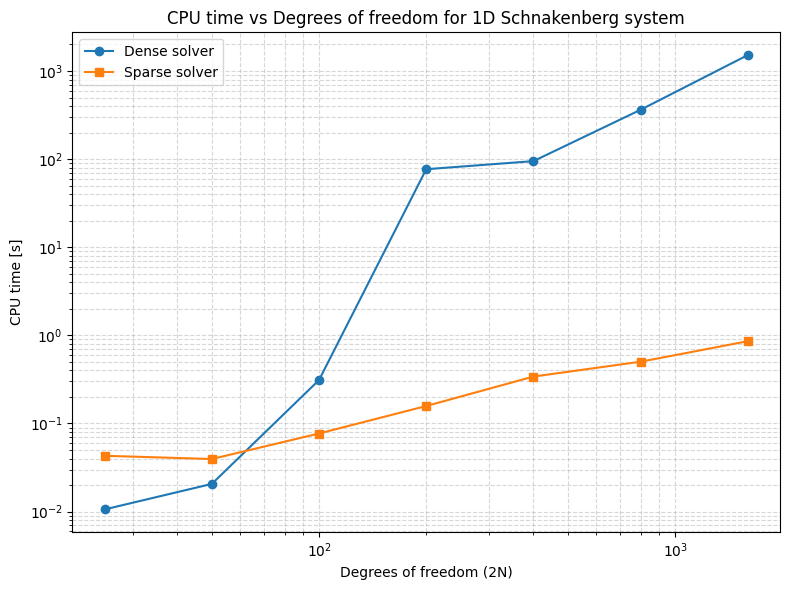

In [7]:
plt.figure(figsize=(8,6))

plt.loglog(Ns, [d[2] for d in results], 'o-', label='Dense solver')
plt.loglog(Ns, [d[3] for d in results], 's-', label='Sparse solver')

plt.xscale('log', base=10)
plt.yscale('log', base=10)

plt.xlabel("Degrees of freedom (2N)")
plt.ylabel("CPU time [s]")
plt.title("CPU time vs Degrees of freedom for 1D Schnakenberg system")
plt.grid(True, which="both", ls="--", alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()